✅ Project Goal Build an image classification model (cats vs. dogs) using:

PyTorch

TensorFlow ✅ Transfer_Learning(MobileNet)

Data Preparation
Use tensorflow.keras.preprocessing

Resize, normalize

Split into train/test (or train/val/test) using sklearn. model_selection.train_test_split

Model Definition
Build a CNN

Or use transfer learning (ResNet or MobileNet)

Training Loop
Track accuracy and loss using Matplotlib

Save best model weights

Evaluation
Confusion matrix

Accuracy, precision, recall using sklearn.metrics

Visualization
Sample predictions

Learning curves

Dataset Using Kaggle's Dogs vs. Cats dataset:
Kaggle Dataset Link: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats

Using colab with "cuda" --> GPU

In [ ]:
from google.colab import files
files.upload()

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d biaiscience/dogs-vs-cats
!unzip -q dogs-vs-cats.zip -d data

Dataset URL: https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats
License(s): DbCL-1.0
 96% 781M/817M [00:09<00:01, 29.2MB/s]
100% 817M/817M [00:09<00:00, 90.3MB/s]


In [7]:
import os

# Replace 'path/to/your/unzipped_folder' with the actual path
FOLDER_PATH = 'dogs-vs-cats.zip'

try:
  item_count = len(os.listdir(FOLDER_PATH))
  print(f"There are {item_count} items in {FOLDER_PATH}")
except FileNotFoundError:
  print(f"{FOLDER_PATH} not found")
except Exception as e:
  print(f"An error occurred: {e}")

An error occurred: [Errno 20] Not a directory: 'dogs-vs-cats.zip'


In [8]:
import os

for root, dirs, files in os.walk("data"):
    print(root)
    for d in dirs:
        print("   Floder", d)

data
   Floder train
   Floder test
data/train
   Floder train
data/train/train
data/test
   Floder test
data/test/test


In [11]:
import os
import shutil

source_dir = 'data/train/train'
target_base = 'data/train/sorted'
os.makedirs(f"{target_base}/cat", exist_ok = True)
os.makedirs(f"{target_base}/dog", exist_ok = True)

for filename in os.listdir(source_dir):
  if filename.startswith("cat" or "cats"):
    shutil.copy(os.path.join(source_dir, filename), os.path.join(target_base, "cat", filename))
  elif filename.startswith("dog" or "dogs"):
    shutil.copy(os.path.join(source_dir, filename), os.path.join(target_base, "dog", filename))

print("Image sorted into folder")

Image sorted into folder


In [12]:
import os

for root, dirs, files in os.walk("data"):
    print(root)
    for d in dirs:
        print("   Floder", d)

data
   Floder train
   Floder test
data/train
   Floder train
   Floder sorted
data/train/train
data/train/sorted
   Floder cat
   Floder dog
data/train/sorted/cat
data/train/sorted/dog
data/test
   Floder test
data/test/test


In [14]:
import os

cat_files = len(os.listdir("data/train/sorted/cat"))
dog_files = len(os.listdir("data/train/sorted/dog"))
print(f" Images in 'cat/': {cat_files}")
print(f" Images in 'dog/': {dog_files}")

 Images in 'cat/': 12500
 Images in 'dog/': 12500


Import Libraries

In [16]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

In [17]:
image_size = (128, 128)
batch_size = 32
train_ds = image_dataset_from_directory(
    'data/train/sorted',
    validation_split = 0.2,
    subset= 'training',
    seed = 50,
    image_size = image_size,
    batch_size = batch_size

)

val_ds = image_dataset_from_directory(
    'data/train/sorted',
    validation_split = 0.2,
    subset= 'validation',
    seed = 50,
    image_size = image_size,
    batch_size = batch_size
)

print(len(train_ds))
print(len(val_ds))


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
625
157


In [18]:
train_samples = train_ds.cardinality().numpy() * batch_size
val_samples = val_ds.cardinality().numpy() * batch_size
print(f"Train samples: {train_samples}")
print(f"Validation samples: {val_samples}")

Train samples: 20000
Validation samples: 5024


## Import & Load MobileNetV2
load pretrained MobileNetV2 without the top layer & freeze base model layers

In [21]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (128, 128, 3),
    include_top= False,
    weights = 'imagenet'
)

base_model.trainable = False

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## Add a Custom Classification head


In [25]:
model = models.Sequential([
    tf.keras.layers.Rescaling(1./255), # Normalizing pixel values
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

compile

In [26]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

Train loop

In [27]:
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 43s 52ms/step - accuracy: 0.9028 - loss: 0.2200 - val_accuracy: 0.9660 - val_loss: 0.0905
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.9620 - loss: 0.0946 - val_accuracy: 0.9676 - val_loss: 0.0845
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9667 - loss: 0.0856 - val_accuracy: 0.9690 - val_loss: 0.0811
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 26s 42ms/step - accuracy: 0.9670 - loss: 0.0831 - val_accuracy: 0.9686 - val_loss: 0.0794
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 45s 48ms/step - accuracy: 0.9702 - loss: 0.0792 - val_accuracy: 0.9698 - val_loss: 0.0812


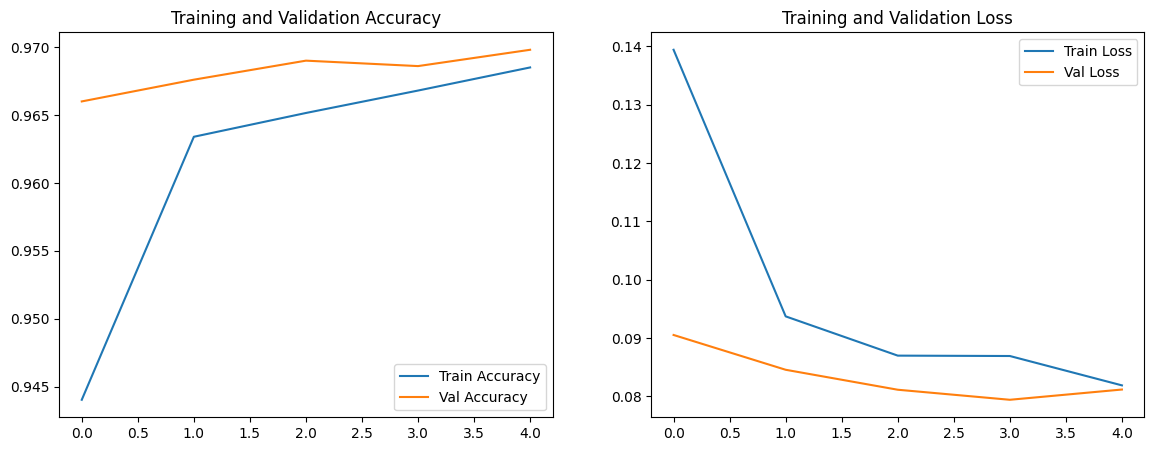

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Save and show
import os
os.makedirs("results", exist_ok=True)
plt.savefig("results/loss_plot_mobilenetv2.png")
plt.show()

In [30]:
model.save("mobilenetv2_model.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


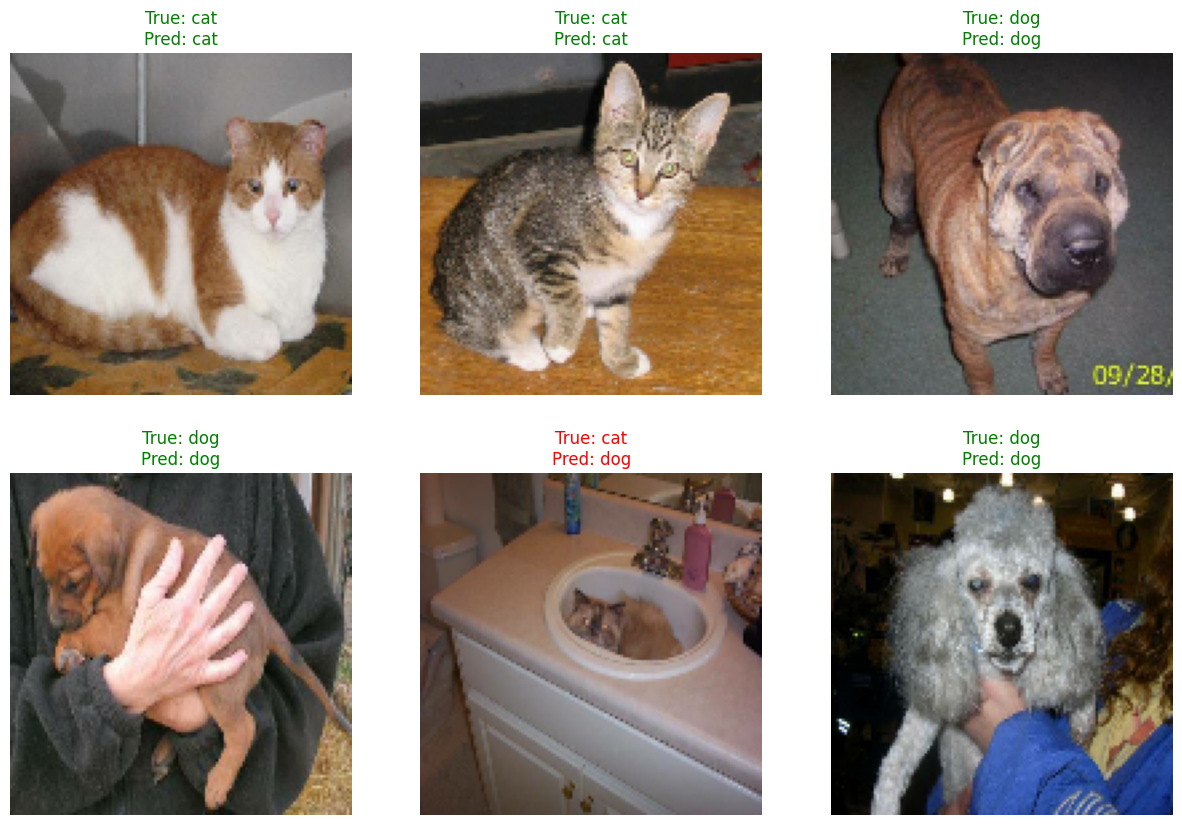

In [31]:
class_names = train_ds.class_names

def show_predictions(model, dataset, class_names, num_images=6):
    import numpy as np
    plt.figure(figsize=(15, 10))
    for images, labels in dataset.take(1):
        preds = model.predict(images)
        preds = tf.squeeze(tf.round(preds)).numpy().astype(int)

        for i in range(num_images):
            ax = plt.subplot(2, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            true_label = class_names[labels[i]]
            pred_label = class_names[preds[i]]
            title_color = "green" if true_label == pred_label else "red"
            plt.title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
            plt.axis("off")

    plt.savefig("results/sample_predictions_mobilenetv2.png")
    plt.show()

show_predictions(model, val_ds, class_names)

In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.round(preds).astype(int).flatten())

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 456ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [33]:
with open("results/metrics_mobilenetv2.txt", "w") as f:
    f.write(classification_report(y_true, y_pred, target_names=class_names))